<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/Similarity_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun  9 07:42:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Loading and processing

In [2]:
!git clone https://github.com/language-ml/course-nlp-ir-1-text-exploring

fatal: destination path 'course-nlp-ir-1-text-exploring' already exists and is not an empty directory.


In [3]:
import random 
import nltk
import pandas as pd
import codecs
import tqdm

# show full verse
pd.set_option('display.max_colwidth', None)

quranic_dir = "/content/course-nlp-ir-1-text-exploring/exploring-datasets/religious_text"
df_quran = pd.read_csv(f'{quranic_dir}/quranic_data/id_text_with_orthographies.txt', sep='\t', header=None)
df_nahj = pd.read_csv(f'{quranic_dir}/nahj-al-balaqa/Nahj Al-Balaqa.txt', sep='\t',header=None)
verse_complete_dict = pd.Series(df_quran[1].tolist(), index=df_quran[0]).to_dict()
nahj_complete_dict = pd.Series(df_nahj[1].tolist(), index=df_nahj[0]).to_dict()

In [4]:
from pathlib import Path
import re
sahife_text=Path(f'{quranic_dir}/Saheefa/sahife_sajjadieh.txt').read_text().split('\n')
sahife_complete_dict = [re.sub('[(][۰-۹]+[)]','', item) for item in sahife_text if item.startswith('(')]

In [5]:
sahife_complete_dict[12]

' حَمْداً یَرْتَفِعُ مِنَّا إِلَی أَعْلَی عِلِّیِّینَ فِي کِتَابٍ مَرْقُومٍ یَشْهَدُه\u200cُ الْمُقَرَّبُونَ. '

In [6]:
nahj_complete_dict['2##186']

'وَ قَالَ ع لِلظّالِمِ الباَدیِ غَداً بِکَفّهِ عَضّةٌ'

In [7]:
verse_complete_dict['2##186']

'وَإِذَا سَأَلَكَ عِبَادِي عَنِّي فَإِنِّي قَرِيبٌ ۖ أُجِيبُ دَعْوَةَ الدَّاعِ إِذَا دَعَانِ ۖ فَلْيَسْتَجِيبُوا لِي وَلْيُؤْمِنُوا بِي لَعَلَّهُمْ يَرْشُدُونَ'

### Normalize

In [8]:
pip install -Uq camel_tools

In [9]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar

from camel_tools.utils.normalize import normalize_alef_bw
from camel_tools.utils.normalize import normalize_alef_hsb

from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar

def normalize_arabic(sentence):

    # Normalize alef variants to 'ا'
    sent_norm = normalize_unicode(sentence)
    
    sent_norm = normalize_alef_bw(sent_norm)
    # Normalize alef variants to 'ا'
    sent_norm = normalize_alef_ar(sentence)

    # Normalize alef maksura 'ى' to yeh 'ي'
    sent_norm = normalize_alef_maksura_ar(sent_norm)

    # Normalize teh marbuta 'ة' to heh 'ه'
    sent_norm = normalize_teh_marbuta_ar(sent_norm)
    return dediac_ar(sent_norm)

In [10]:
from camel_tools.utils import normalize


verse_complete_dict_nrmlz = {k:normalize_arabic(v) for k,v in tqdm.tqdm(verse_complete_dict.items())}
nahj_complete_dict_nrmlz = {k:normalize_arabic(v) for k,v in tqdm.tqdm(nahj_complete_dict.items())}
sahife_complete_dict_nrmlz = [normalize_arabic(item) for item in tqdm.tqdm(sahife_complete_dict)]

100%|██████████| 924/924 [00:00<00:00, 7711.61it/s]


In [11]:
print(verse_complete_dict['2##186'])
print(verse_complete_dict_nrmlz['2##186'])

print(nahj_complete_dict['2##186'])
print(nahj_complete_dict_nrmlz['2##186'])

print(sahife_complete_dict[34])
print(sahife_complete_dict_nrmlz[34])

وَإِذَا سَأَلَكَ عِبَادِي عَنِّي فَإِنِّي قَرِيبٌ ۖ أُجِيبُ دَعْوَةَ الدَّاعِ إِذَا دَعَانِ ۖ فَلْيَسْتَجِيبُوا لِي وَلْيُؤْمِنُوا بِي لَعَلَّهُمْ يَرْشُدُونَ
واذا سالك عبادي عني فاني قريب ۖ اجيب دعوه الداع اذا دعان ۖ فليستجيبوا لي وليؤمنوا بي لعلهم يرشدون
وَ قَالَ ع لِلظّالِمِ الباَدیِ غَداً بِکَفّهِ عَضّةٌ
و قال ع للظالم البادی غدا بکفه عضه
 وَ کَاشَفَ فِي الدُّعَاءِ إِلَیْکَ حَامَّتَه‌ُ 
 و کاشف في الدعاء الیک حامته‌ 


In [12]:
quranic_tokenized = [sents.split() for sents in tqdm.tqdm(verse_complete_dict_nrmlz.values())]
nahj_tokenized = [sents.split() for sents in tqdm.tqdm(nahj_complete_dict_nrmlz.values())]
sahife_tokenized = [sents.split() for sents in tqdm.tqdm(sahife_complete_dict_nrmlz)]

100%|██████████| 924/924 [00:00<00:00, 39602.87it/s]


(array([224., 255., 200., 122.,  69.,  32.,  16.,   3.,   2.,   1.]),
 array([  3. ,  13.7,  24.4,  35.1,  45.8,  56.5,  67.2,  77.9,  88.6,
         99.3, 110. ]),
 <a list of 10 Patch objects>)

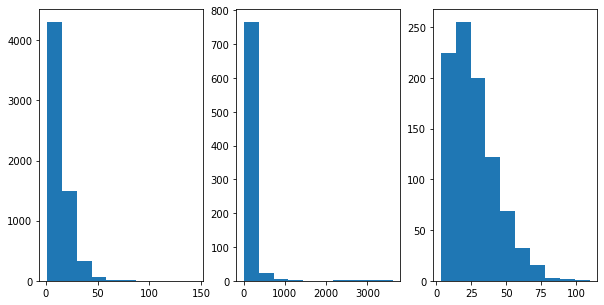

In [13]:
import matplotlib.pyplot as plt
size_quran_token = [len(sentence) for sentence in quranic_tokenized]
size_nahj_token =[len(sentence) for sentence in nahj_tokenized]
size_sahife_token = [len(sentence) for sentence in sahife_tokenized]
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(10,5))
axes[0].hist(size_quran_token)
axes[1].hist(size_nahj_token)
axes[2].hist(size_sahife_token)

# Common Modules

In [14]:
pip install transformers -Uqq

In [15]:
def tokenize(sentence_list):
    return tokenizer.batch_encode_plus(sentence_list,
                    add_special_tokens=True,
                    max_length=128,
                    padding='max_length',
                    return_attention_mask=True,
                    truncation=True,
                    return_tensors='pt')

In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset

def get_mean_embedding(model,sentences,batch_size=128):
    encoding= tokenize(sentences)

    dataset=TensorDataset(encoding.input_ids, encoding.attention_mask)
    dataloader = DataLoader(dataset,batch_size=batch_size
                            ,drop_last=False,shuffle=False)

    predictions = []
    with torch.no_grad():
        for (input_ids, attention_mask) in dataloader:
            prediction = model(input_ids.to(device),
                               attention_mask.to(device))
            predictions.append(prediction.last_hidden_state)

    predictions = torch.cat(predictions,dim=0)

    attention_mask=encoding.attention_mask.unsqueeze(-1) \
                    .expand(predictions.shape).float()
    # for filtering out unnecessary ones
    mask_embeddings=predictions.cpu() * attention_mask

    summed = torch.sum(mask_embeddings,dim=1)
    count = torch.clamp(attention_mask.sum(dim=1),min=1e-9)
    mean_embedding = summed / count

    return mean_embedding

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def get_most_similar(mean_embedding,compare_verse_no):
    mean_embedding = mean_embedding.numpy()
    similarity=cosine_similarity(
        [mean_embedding[compare_verse_no]],
        mean_embedding 
    ).squeeze()
    
    most_similar=similarity.argsort()[-15:][::-1]
    return most_similar

# Similarity without finetuning

## Loading Bert Model

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic
# https://www.youtube.com/watch?v=jVPd7lEvjtg

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

model=model.to(device)

model.eval()

device

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

## Extract Embedding Vectors

In [ ]:
mean_embedding = get_mean_embedding(model,list(verse_complete_dict_nrmlz.values()))

## Compute Similarity Score

In [ ]:
compare_to = 30

most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(verse_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

['فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين']


,0
30,فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين
689,يا قوم ادخلوا الارض المقدسه التي كتب الله لكم ولا ترتدوا علي ادباركم فتنقلبوا خاسرين
1195,ان الذين كفروا ينفقون اموالهم ليصدوا عن سبيل الله ۚ فسينفقونها ثم تكون عليهم حسره ثم يغلبون ۗ والذين كفروا الي جهنم يحشرون
3522,واما الذين فسقوا فماواهم النار ۖ كلما ارادوا ان يخرجوا منها اعيدوا فيها وقيل لهم ذوقوا عذاب النار الذي كنتم به تكذبون
86,وقالوا لن تمسنا النار الا اياما معدوده ۚ قل اتخذتم عند الله عهدا فلن يخلف الله عهده ۖ ام تقولون علي الله ما لا تعلمون
3351,وقال الذين كفروا للذين امنوا اتبعوا سبيلنا ولنحمل خطاياكم وما هم بحاملين من خطاياهم من شيء ۖ انهم لكاذبون
316,ذلك بانهم قالوا لن تمسنا النار الا اياما معدودات ۖ وغرهم في دينهم ما كانوا يفترون
45,والذين كفروا وكذبوا باياتنا اولئك اصحاب النار ۖ هم فيها خالدون
2241,افحسب الذين كفروا ان يتخذوا عبادي من دوني اولياء ۚ انا اعتدنا جهنم للكافرين نزلا
459,وليعلم الذين نافقوا ۚ وقيل لهم تعالوا قاتلوا في سبيل الله او ادفعوا ۖ قالوا لو نعلم قتالا لاتبعناكم ۗ هم للكفر يومئذ اقرب منهم للايمان ۚ يقولون بافواههم ما ليس في قلوبهم ۗ والله اعلم بما يكتمون


In [ ]:
mean_embedding = get_mean_embedding(model,list(nahj_complete_dict_nrmlz.values()))
compare_to =10 
most_similar=get_most_similar(mean_embedding, compare_to)
verse_complete=pd.DataFrame(nahj_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)
verse_complete.iloc[most_similar]

['تزول الجبال و لا تزل عض علی ناجذک اعر الله جمجمتک تد فی الارض قدمک ارم ببصرک اقصی القوم و غض بصرک و اعلم ان النصر من عند الله سبحانه']


,0
10,تزول الجبال و لا تزل عض علی ناجذک اعر الله جمجمتک تد فی الارض قدمک ارم ببصرک اقصی القوم و غض بصرک و اعلم ان النصر من عند الله سبحانه
183,اسکت قبحک الله یا اثرم فوالله لقد ظهر الحق فکنت فیه ضئیلا شخصک خفیا صوتک حتی اذا نعر الباطل نجمت نجوم قرن الماعز
255,اللهم الیک افضت القلوب و مدت الاعناق و شخصت الابصار و نقلت الاقدام و انضیت الابدان اللهم قد صرح مکنون الشنان و جاشت مراجل الاضغان اللهم انا نشکو الیک غیبه نبینا و کثره عدونا و تشتت اهوائناربنا افتح بیننا و بین قومنا بالحق و انت خیر الفاتحین
148,ایها الناس کل امر‌ئ لاق ما یفر منه فی فراره الاجل مساق النفس و الهرب منه موافاته کم اطردت الایام ابحثها عن مکنون هذا الامر فابی الله الا اخفاءه هیهات علم مخزون اما وصیتی فالله لا تشرکوا به شیئا و محمدا ص فلا تضیعوا سنته اقیموا هذین العمودین و اوقدوا هذین المصباحین و خلاکم ذم ما لم تشردوا حمل کل امر‌ئ منکم مجهوده و خفف عن الجهله رب رحیم و دین قویم و امام علیم انا بالامس صاحبکم و انا الیوم عبره لکم و غدا مفارقکم غفر الله لی و لکم ان تثبت الوطاه فی هذه المزله فذاک و ان تدحض القدم فانا کنا فی افیاء اغصان و مهاب ریاح و تحت ظل غمام اضمحل فی الجو متلفقها و عفا فی الارض مخطها و انما کنت جارا جاورکم بدنی ایاما و ستعقبون منی جثه خلاء ساکنه بعد حراک و صامته بعد نطق لیعظکم هدوی و خفوت اطراقی و سکون اطرافی فانه اوعظ للمعتبرین من المنطق البلیغ و القول المسموع وداعی لکم وداع امر‌ئ مرصد للتلاقی غدا ترون ایامی و یکشف لکم عن سرائری و تعرفوننی بعد خلو مکانی و قیام غیری مقامی‌
710,و قال ع ازهد فی الدنیا یبصرک الله عوراتها و لا تغفل فلست بمغفول عنک
68,کم اداریکم کما تداری البکار العمده و الثیاب المتداعیه کلما حیصت من جانب تهتکت من اخر کلما اطل علیکم منسر من مناسر اهل الشام اغلق کل رجل منکم بابه و انجحر انجحار الضبه فی جحرها و الضبع فی وجارها الذلیل و الله من نصرتموه و من رمی‌ بکم فقد رمی‌ بافوق ناصل انکم و الله لکثیر فی الباحات قلیل تحت الرایات و انی لعالم بما یصلحکم و یقیم اودکم و لکنی لا اری اصلاحکم بافساد نفسی اضرع الله خدودکم و اتعس جدودکم لا تعرفون الحق کمعرفتکم الباطل و لا تبطلون الباطل کابطالکم الحق
529,و قال ع اتقوا الله تقیه من شمر تجریدا و جد تشمیرا و کمش فی مهل و بادر عن وجل و نظر فی کره الموئل و عاقبه المصدر و مغبه المرجع
239,یا ابن عباس ما یرید عثمان الا ان یجعلنی جملا ناضحا بالغرب اقبل و ادبر بعث الی‌ ان اخرج ثم بعث الی‌ ان اقدم ثم هو الان یبعث الی‌ ان اخرج و الله لقد دفعت عنه حتی خشیت ان اکون اثما
230,فصدع بما امر به و بلغ رسالات ربه فلم الله به الصدع و رتق به الفتق و الف به الشمل بین ذوی الارحام بعد العداوه الواغره فی الصدور و الضغائن القادحه فی القلوب
47,الحمد لله کلما وقب لیل و غسق و الحمد لله کلما لاح نجم و خفق و الحمد لله غیر مفقود الانعام و لا مکافا الافضال اما بعد فقد بعثت مقدمتی و امرتهم بلزوم هذا الملطاط حتی یاتیهم امری و قد رایت ان اقطع هذه النطفه الی شرذمه منکم موطنین اکناف دجله فانهضهم معکم الی عدوکم و اجعلهم من امداد القوه لکم


In [ ]:
mean_embedding = get_mean_embedding(model,list(sahife_complete_dict_nrmlz))
compare_to =10 
most_similar=get_most_similar(mean_embedding, compare_to)
verse_complete=pd.DataFrame(sahife_complete_dict_nrmlz)
print(verse_complete.iloc[compare_to].values)
verse_complete.iloc[most_similar]

[' حمدا نعمر به\u200c فیمن حمده\u200c من خلقه\u200c، و نسبق به\u200c من سبق الی رضاه\u200c و عفوه\u200c. ']


,0
10,حمدا نعمر به‌ فیمن حمده‌ من خلقه‌، و نسبق به‌ من سبق الی رضاه‌ و عفوه‌.
744,حمدا لا حمد اقرب الی قولک منه‌، و لا احمد ممن یحمدک به‌.
634,یا من تحمد الی عباده‌ بالاحسان و الفضل، و غمرهم بالمن و الطول، ما افشی فینا نعمتک، و اسبغ علینا منتک، و اخصنا ببرک!
743,حمدا یجمع ما خلقت من الحمد، و ینتظم ما انت خالقه‌ من بعد.
735,حمدا یستدام به‌ الاول، و یستدعی به‌ دوام الاخر.
739,حمدا یکمل لدیک ثوابه‌، و یستغرق کل جزاء جزاؤه‌
528,و لا یبلغ مبلغا من طاعتک و ان اجتهد الا کان مقصرا دون استحقاقک بفضلک
741,حمدا لم یحمدک خلق مثله‌، و لا یعرف احد سواک فضله‌
128,و اجزل لنا فیه‌ من الحسنات، و اخلنا فیه‌ من السیئات، و املا لنا ما بین طرفیه‌ حمدا و شکرا و اجرا و ذخرا و فضلا و احسانا.
369,اللهم صل علی محمد و اله‌ کما شرفتنا به‌، و صل علی محمد و اله‌، کما اوجبت لنا الحق علی الخلق بسببه‌.


# Similarity with fine-tunning

In [ ]:
pip install transformers -Uqq

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from transformers import AdamW
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic

tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = BertForMaskedLM.from_pretrained("asafaya/bert-base-arabic")

model=model.to(device)
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
raw_data = list(verse_complete_dict_nrmlz.values())
raw_data= raw_data+list(nahj_complete_dict_nrmlz.values())
raw_data= raw_data +list(sahife_complete_dict_nrmlz)
inputs=tokenize(raw_data)
inputs['labels'] = inputs.input_ids.detach().clone()

In [ ]:
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)
mask_arr

tensor([[False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [ ]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103 #masked_tokens

In [ ]:
from tqdm import tqdm  # for our progress bar

BATCH_SIZE = 64
from torch.utils.data import TensorDataset, DataLoader
dataset=TensorDataset(inputs.input_ids, inputs.attention_mask,inputs.labels)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,drop_last=False,shuffle=True)


epochs = 10

for epoch in range(epochs):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        optim.zero_grad()

        input_ids, attention_mask,labels = batch
        outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device),
                        labels=labels.to(device))
        loss = outputs.loss
        loss.backward()
        optim.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


model.save_pretrained("model-trained-on-arabic")

Epoch 9: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s, loss=0.0129]


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("model-trained-on-arabic")
model=model.to(device)
model.eval()
device

Some weights of the model checkpoint at model-trained-on-arabic were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at model-trained-on-arabic and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weig

'cuda'

In [ ]:
mean_embedding = get_mean_embedding(model,list(verse_complete_dict_nrmlz.values()))

In [ ]:
compare_to = 30

most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(verse_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

['فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين']


,0
30,فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين
689,يا قوم ادخلوا الارض المقدسه التي كتب الله لكم ولا ترتدوا علي ادباركم فتنقلبوا خاسرين
3522,واما الذين فسقوا فماواهم النار ۖ كلما ارادوا ان يخرجوا منها اعيدوا فيها وقيل لهم ذوقوا عذاب النار الذي كنتم به تكذبون
5234,يا ايها الذين امنوا قوا انفسكم واهليكم نارا وقودها الناس والحجاره عليها ملائكه غلاظ شداد لا يعصون الله ما امرهم ويفعلون ما يؤمرون
5116,ااشفقتم ان تقدموا بين يدي نجواكم صدقات ۚ فاذ لم تفعلوا وتاب الله عليكم فاقيموا الصلاه واتوا الزكاه واطيعوا الله ورسوله ۚ والله خبير بما تعملون
3638,وقال الذين استضعفوا للذين استكبروا بل مكر الليل والنهار اذ تامروننا ان نكفر بالله ونجعل له اندادا ۚ واسروا الندامه لما راوا العذاب وجعلنا الاغلال في اعناق الذين كفروا ۚ هل يجزون الا ما كانوا يعملون
999,وبينهما حجاب ۚ وعلي الاعراف رجال يعرفون كلا بسيماهم ۚ ونادوا اصحاب الجنه ان سلام عليكم ۚ لم يدخلوها وهم يطمعون
3351,وقال الذين كفروا للذين امنوا اتبعوا سبيلنا ولنحمل خطاياكم وما هم بحاملين من خطاياهم من شيء ۖ انهم لكاذبون
441,يا ايها الذين امنوا ان تطيعوا الذين كفروا يردوكم علي اعقابكم فتنقلبوا خاسرين
4548,فاذا لقيتم الذين كفروا فضرب الرقاب حتي اذا اثخنتموهم فشدوا الوثاق فاما منا بعد واما فداء حتي تضع الحرب اوزارها ۚ ذلك ولو يشاء الله لانتصر منهم ولكن ليبلو بعضكم ببعض ۗ والذين قتلوا في سبيل الله فلن يضل اعمالهم


In [ ]:
mean_embedding = get_mean_embedding(model,list(nahj_complete_dict_nrmlz.values()))
compare_to = 30

most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(nahj_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

['لا تلقین طلحه فانک ان تلقه تجده کالثور عاقصا قرنه یرکب الصعب و یقول هو الذلول و لکن الق الزبیر فانه الین عریکه فقل له یقول لک ابن خالک عرفتنی بالحجاز و انکرتنی بالعراق فما عدا مما بدا']


,0
30,لا تلقین طلحه فانک ان تلقه تجده کالثور عاقصا قرنه یرکب الصعب و یقول هو الذلول و لکن الق الزبیر فانه الین عریکه فقل له یقول لک ابن خالک عرفتنی بالحجاز و انکرتنی بالعراق فما عدا مما بدا
208,ما کنت تصنع بسعه هذه الدار فی الدنیا و انت الیها فی الاخره کنت احوج و بلی ان شئت بلغت بها الاخره تقری فیها الضیف و تصل فیها الرحم و تطلع منها الحقوق مطالعها فاذا انت قد بلغت بها الاخره فقال له العلاء یا امیر المؤمنین اشکو الیک اخی عاصم بن زیاد قال و ما له قال لبس العباءه و تخلی عن الدنیا قال علی به فلما جاء قال یا عدی‌ نفسه لقد استهام بک الخبیث ا ما رحمت اهلک و ولدک ا تری الله احل لک الطیبات و هو یکره ان تاخذها انت اهون علی الله من ذلک قال یا امیر المؤمنین هذا انت فی خشونه ملبسک و جشوبه ماکلک قال ویحک انی لست کانت ان الله تعالی فرض علی ائمه العدل ان یقدروا انفسهم بضعفه الناس کیلا یتبیغ بالفقیر فقره
396,و من خبر ضرار بن حمزه الضبائی‌ عند دخوله علی معاویه و مسالته له عن امیر المؤمنین ع و قال فاشهد لقد رایته فی بعض مواقفه و قد ارخی اللیل سدوله و هو قائم فی محرابه قابض علی لحیته یتململ تململ السلیم و یبکی بکاء الحزین و یقول یا دنیا یا دنیا الیک عنی ا بی تعرضت ام الی‌ تشوقت لا حان حینک هیهات غری غیری لا حاجه لی فیک قد طلقتک ثلاثا لا رجعه فیها فعیشک قصیر و خطرک یسیر و املک حقیر اه من قله الزاد و طول الطریق و بعد السفر و عظیم المورد
241,من عبد الله علی امیر المؤمنین الی اهل الکوفه جبهه الانصار و سنام العرب اما بعد فانی اخبرکم عن امر عثمان حتی یکون سمعه کعیانه ان الناس طعنوا علیه فکنت رجلا من المهاجرین اکثر استعتابه و اقل عتابه و کان طلحه و الزبیر اهون سیرهما فیه الوجیف و ارفق حدائهما العنیف و کان من عائشه فیه فلته غضب فاتیح له قوم فقتلوه و بایعنی الناس غیر مستکرهین و لا مجبرین بل طائعین مخیرین و اعلموا ان دار الهجره قد قلعت باهلها و قلعوا بها و جاشت جیش المرجل و قامت الفتنه علی القطب فاسرعوا الی امیرکم و بادروا جهاد عدوکم ان شاء الله عز و جل
243,و روی‌ ان شریح بن الحارث قاضی‌ امیر المؤمنین ع اشتری علی عهده دارا بثمانین دینارا فبلغه ذلک فاستدعی شریحا و قال له بلغنی انک ابتعت دارا بثمانین دینارا و کتبت لها کتابا و اشهدت فیه شهودا فقال له شریح قد کان ذلک یا امیر المؤمنین قال فنظر الیه نظر المغضب ثم قال له یا شریح اما انه سیاتیک من لا ینظر فی کتابک و لا یسالک عن بینتک حتی یخرجک منها شاخصا و یسلمک الی قبرک خالصا فانظر یا شریح لا تکون ابتعت هذه الدار من غیر مالک او نقدت الثمن من غیر حلالک فاذا انت قد خسرت دار الدنیا و دار الاخره. اما انک لو کنت اتیتنی عند شرائک ما اشتریت لکتبت لک کتابا علی هذه النسخه فلم ترغب فی شراء هذه الدار بدرهم فما فوق و النسخه هذه هذا ما اشتری عبد ذلیل من میت قد ازعج للرحیل اشتری منه دارا من دار الغرور من جانب الفانین و خطه الهالکین و تجمع هذه الدار حدود اربعه الحد الاول ینتهی الی دواعی الافات و الحد الثانی ینتهی الی دواعی المصیبات و الحد الثالث ینتهی الی الهوی المردی و الحد الرابع ینتهی الی الشیطان المغوی و فیه یشرع باب هذه الدار اشتری هذا المغتر بالامل من هذا المزعج بالاجل هذه الدار بالخروج من عز القناعه و الدخول فی ذل الطلب و الضراعه فما ادرک هذا المشتری فیما اشتری منه من درک فعلی مبلبل اجسام الملوک و سالب نفوس الجبابره و مزیل ملک الفراعنه مثل کسری و قیصر و تبع و حمیر و من جمع المال علی المال فاکثر و من بنی و شید و زخرف و نجد و ادخر و اعتقد و نظر بزعمه للولد اشخاصهم جمیعا الی موقف العرض و الحساب و موضع الثواب و العقاب اذا وقع الامر بفصل القضاءو خسر هنالک المبطلونشهد علی ذلک العقل اذا خرج من اسر الهوی و سلم من علائق الدنیا
18,ما یدریک ما علی مما لی علیک لعنه الله و لعنه اللاعنین حائک ابن حائک منافق ابن کافر و الله لقد اسرک الکفر مره و الاسلام اخری فما فداک من واحده منهما مالک و لا حسبک و ان امرا دل علی قومه السیف و ساق الیهم الحتف لحری‌ ان یمقته الاقرب و لا یامنه الابعد
608,و قال ع کان لی فیما مضی اخ فی الله و کان یعظمه فی عینی صغر الدنیا فی عینه و کان خارجا من سلطان بطنه فلا یشتهی ما لا یجد و لا یکثر اذا وجد و کان اکثر دهره صامتا فان قال بذ القائلین و نقع غلیل السائلین و کان ضعیفا مستضعفا فان جاء الجد فهو لیث غاب و صل واد لا یدلی بحجه حتی یاتی‌ قاضیا و کان لا یلوم احدا علی ما یجد العذر فی مثله حتی یسمع اعتذاره و کان لا یشکو وجعا الا عند برئه و کان یقول ما یفعل و لا یقول ما لا یفعل و کان اذا غلب علی الکلام لم یغلب علی السکوت و کان علی ما یسمع احرص منه علی ان یتکلم و کان اذا بدهه امران ینظر ایهما اقرب الی الهوی فیخالفه فعلیکم

In [ ]:
mean_embedding = get_mean_embedding(model,list(sahife_complete_dict_nrmlz))
compare_to = 30

most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(sahife_complete_dict_nrmlz)
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

[' فختم بنا علی جمیع من ذرا، و جعلنا شهداء علی من جحد، و کثرنا بمنه\u200c علی من قل.  ']


,0
30,فختم بنا علی جمیع من ذرا، و جعلنا شهداء علی من جحد، و کثرنا بمنه‌ علی من قل.
664,اللهم صل علی محمد و اله‌، و اجبر مصیبتنا بشهرنا، و بارک لنا في یوم عیدنا و فطرنا، و اجعله‌ من خیر یوم مر علینا اجلبه‌ لعفو، و امحاه‌ لذنب، و اغفر لنا ما خفي من ذنوبنا و ما علن.
663,اللهم و ما الممنا به‌ في شهرنا هذا من لمم او اثم، او واقعنا فیه‌ من ذنب، و اکتسبنا فیه‌ من خطیئه علی تعمد منا، او علی نسیان ظلمنا فیه‌ انفسنا، او انتهکنا به‌ حرمه من غیرنا، فصل علی محمد و اله‌، و استرنا بسترک، و اعف عنا بعفوک، و لا تنصبنا فیه‌ لاعین الشامتین، و لا تبسط علینا فیه‌ السن الطاعنین، و استعملنا بما یکون حطه و کفاره لما انکرت منا فیه‌ برافتک التي لا تنفد، و فضلک الذي لا ینقص.
505,و الهمنا معرفه الاختیار، و اجعل ذلک ذریعه الی الرضا بما قضیت لنا و التسلیم لما حکمت فازح عنا ریب الارتیاب، و ایدنا بیقین المخلصین.
369,اللهم صل علی محمد و اله‌ کما شرفتنا به‌، و صل علی محمد و اله‌، کما اوجبت لنا الحق علی الخلق بسببه‌.
873,هذا مقام من اعترف بسبوغ النعم، و قابلها بالتقصیر، و شهد علی نفسه‌ بالتضییع.
22,فما هکذا کانت سنته‌ في التوبه لمن کان قبلنا، لقد وضع عنا ما لا طاقه لنا به‌، و لم یکلفنا الا وسعا، و لم یجشمنا الا یسرا، و لم یدع لاحد منا حجه و لا عذرا.
574,اللهم فکما جعلت قلوبنا له‌ حمله، و عرفتنا برحمتک شرفه‌ و فضله‌، فصل علی محمد الخطیب به‌، و علی اله‌ الخزان له‌، و اجعلنا ممن یعترف بانه‌ من عندک حتی لا یعارضنا الشک في تصدیقه‌، و لا یختلجنا الزیغ عن قصد طریقه‌.
671,اللهم تجاوز عن ابائنا و امهاتنا و اهل دیننا جمیعا من سلف منهم و من غبر الی یوم القیامه.
661,اللهم فلک الحمد اقرارا بالاساءه، و اعترافا بالاضاعه، و لک من قلوبنا عقد الندم، و من السنتنا صدق الاعتذار، فاجرنا علی ما اصابنا فیه‌ من التفریط اجرا نستدرک به‌ الفضل المرغوب فیه‌، و نعتاض به‌ من انواع الذخر المحروص علیه‌.


# Finetune- A lot! 

In [18]:
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm  # for our progress bar
import torch
from transformers import AdamW
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic

tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = BertForMaskedLM.from_pretrained("asafaya/bert-base-arabic")

model=model.to(device)
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

raw_data = list(verse_complete_dict_nrmlz.values())
raw_data= raw_data+list(nahj_complete_dict_nrmlz.values())
raw_data= raw_data +list(sahife_complete_dict_nrmlz)

def mask_text(raw_data):
    inputs=tokenize(raw_data)
    inputs['labels'] = inputs.input_ids.detach().clone()
    
    rand = torch.rand(inputs.input_ids.shape)
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
            (inputs.input_ids != 102) * (inputs.input_ids != 0)
            
    selection = []
    for i in range(inputs.input_ids.shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )
    
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103 #masked_tokens

    BATCH_SIZE = 64
    dataset=TensorDataset(inputs.input_ids, inputs.attention_mask,inputs.labels)
    dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,drop_last=False,shuffle=True)
    return dataloader    


epochs = 30 

def train(model,dataloader,optim,epochs):
    for epoch in range(epochs):
        
        if (epoch+1) % 5 == 0:
            dataloader = mask_text(raw_data)

        loop = tqdm(dataloader, leave=True)
        for batch in loop:
            optim.zero_grad()

            input_ids, attention_mask,labels = batch
            outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device),
                            labels=labels.to(device))
            loss = outputs.loss
            loss.backward()
            optim.step()
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

train(model,mask_text(raw_data),optim,epochs)
model.save_pretrained("model-trained-on-arabic")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 29: 100%|██████████| 125/125 [03:24<00:00,  1.63s/it, loss=0.105]


In [20]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [24]:
tokenizer.save_pretrained('arabic-quran-nahj-sahife/')
model.push_to_hub('arabic-quran-nahj-sahife')

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/pourmand1376/arabic-quran-nahj-sahife
   03d579f..39bbd8f  main -> main



'https://huggingface.co/pourmand1376/arabic-quran-nahj-sahife/commit/39bbd8f5c9168e2df6411ff3ad2d3978bd623df2'

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("model-trained-on-arabic")
model=model.to(device)
model.eval()
device

Some weights of the model checkpoint at model-trained-on-arabic were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at model-trained-on-arabic and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bi

'cuda'

In [29]:
compare_to = 30
mean_embedding = get_mean_embedding(model,list(verse_complete_dict_nrmlz.values()))
most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(verse_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

['فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين']


,0
30,فان لم تفعلوا ولن تفعلوا فاتقوا النار التي وقودها الناس والحجاره ۖ اعدت للكافرين
5234,يا ايها الذين امنوا قوا انفسكم واهليكم نارا وقودها الناس والحجاره عليها ملائكه غلاظ شداد لا يعصون الله ما امرهم ويفعلون ما يؤمرون
689,يا قوم ادخلوا الارض المقدسه التي كتب الله لكم ولا ترتدوا علي ادباركم فتنقلبوا خاسرين
384,لن تنالوا البر حتي تنفقوا مما تحبون ۚ وما تنفقوا من شيء فان الله به عليم
1194,وما كان صلاتهم عند البيت الا مكاء وتصديه ۚ فذوقوا العذاب بما كنتم تكفرون
5116,ااشفقتم ان تقدموا بين يدي نجواكم صدقات ۚ فاذ لم تفعلوا وتاب الله عليكم فاقيموا الصلاه واتوا الزكاه واطيعوا الله ورسوله ۚ والله خبير بما تعملون
1779,وجعلوا لله اندادا ليضلوا عن سبيله ۗ قل تمتعوا فان مصيركم الي النار
3666,الذين كفروا لهم عذاب شديد ۖ والذين امنوا وعملوا الصالحات لهم مغفره واجر كبير
1232,والذين كفروا بعضهم اولياء بعض ۚ الا تفعلوه تكن فتنه في الارض وفساد كبير
1297,الم يعلموا انه من يحادد الله ورسوله فان له نار جهنم خالدا فيها ۚ ذلك الخزي العظيم


In [30]:
compare_to = 30
mean_embedding = get_mean_embedding(model,list(nahj_complete_dict_nrmlz.values()))
most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(nahj_complete_dict_nrmlz.values())
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

['لا تلقین طلحه فانک ان تلقه تجده کالثور عاقصا قرنه یرکب الصعب و یقول هو الذلول و لکن الق الزبیر فانه الین عریکه فقل له یقول لک ابن خالک عرفتنی بالحجاز و انکرتنی بالعراق فما عدا مما بدا']


,0
30,لا تلقین طلحه فانک ان تلقه تجده کالثور عاقصا قرنه یرکب الصعب و یقول هو الذلول و لکن الق الزبیر فانه الین عریکه فقل له یقول لک ابن خالک عرفتنی بالحجاز و انکرتنی بالعراق فما عدا مما بدا
208,ما کنت تصنع بسعه هذه الدار فی الدنیا و انت الیها فی الاخره کنت احوج و بلی ان شئت بلغت بها الاخره تقری فیها الضیف و تصل فیها الرحم و تطلع منها الحقوق مطالعها فاذا انت قد بلغت بها الاخره فقال له العلاء یا امیر المؤمنین اشکو الیک اخی عاصم بن زیاد قال و ما له قال لبس العباءه و تخلی عن الدنیا قال علی به فلما جاء قال یا عدی‌ نفسه لقد استهام بک الخبیث ا ما رحمت اهلک و ولدک ا تری الله احل لک الطیبات و هو یکره ان تاخذها انت اهون علی الله من ذلک قال یا امیر المؤمنین هذا انت فی خشونه ملبسک و جشوبه ماکلک قال ویحک انی لست کانت ان الله تعالی فرض علی ائمه العدل ان یقدروا انفسهم بضعفه الناس کیلا یتبیغ بالفقیر فقره
585,و ساله رجل ان یعرفه الایمان فقال ع اذا کان الغد فاتنی حتی اخبرک علی اسماع الناس فان نسیت مقالتی حفظها علیک غیرک فان الکلام کالشارده ینقفها هذا و یخطئها هذا
243,و روی‌ ان شریح بن الحارث قاضی‌ امیر المؤمنین ع اشتری علی عهده دارا بثمانین دینارا فبلغه ذلک فاستدعی شریحا و قال له بلغنی انک ابتعت دارا بثمانین دینارا و کتبت لها کتابا و اشهدت فیه شهودا فقال له شریح قد کان ذلک یا امیر المؤمنین قال فنظر الیه نظر المغضب ثم قال له یا شریح اما انه سیاتیک من لا ینظر فی کتابک و لا یسالک عن بینتک حتی یخرجک منها شاخصا و یسلمک الی قبرک خالصا فانظر یا شریح لا تکون ابتعت هذه الدار من غیر مالک او نقدت الثمن من غیر حلالک فاذا انت قد خسرت دار الدنیا و دار الاخره. اما انک لو کنت اتیتنی عند شرائک ما اشتریت لکتبت لک کتابا علی هذه النسخه فلم ترغب فی شراء هذه الدار بدرهم فما فوق و النسخه هذه هذا ما اشتری عبد ذلیل من میت قد ازعج للرحیل اشتری منه دارا من دار الغرور من جانب الفانین و خطه الهالکین و تجمع هذه الدار حدود اربعه الحد الاول ینتهی الی دواعی الافات و الحد الثانی ینتهی الی دواعی المصیبات و الحد الثالث ینتهی الی الهوی المردی و الحد الرابع ینتهی الی الشیطان المغوی و فیه یشرع باب هذه الدار اشتری هذا المغتر بالامل من هذا المزعج بالاجل هذه الدار بالخروج من عز القناعه و الدخول فی ذل الطلب و الضراعه فما ادرک هذا المشتری فیما اشتری منه من درک فعلی مبلبل اجسام الملوک و سالب نفوس الجبابره و مزیل ملک الفراعنه مثل کسری و قیصر و تبع و حمیر و من جمع المال علی المال فاکثر و من بنی و شید و زخرف و نجد و ادخر و اعتقد و نظر بزعمه للولد اشخاصهم جمیعا الی موقف العرض و الحساب و موضع الثواب و العقاب اذا وقع الامر بفصل القضاءو خسر هنالک المبطلونشهد علی ذلک العقل اذا خرج من اسر الهوی و سلم من علائق الدنیا
396,و من خبر ضرار بن حمزه الضبائی‌ عند دخوله علی معاویه و مسالته له عن امیر المؤمنین ع و قال فاشهد لقد رایته فی بعض مواقفه و قد ارخی اللیل سدوله و هو قائم فی محرابه قابض علی لحیته یتململ تململ السلیم و یبکی بکاء الحزین و یقول یا دنیا یا دنیا الیک عنی ا بی تعرضت ام الی‌ تشوقت لا حان حینک هیهات غری غیری لا حاجه لی فیک قد طلقتک ثلاثا لا رجعه فیها فعیشک قصیر و خطرک یسیر و املک حقیر اه من قله الزاد و طول الطریق و بعد السفر و عظیم المورد
268,اما بعد فقد اتانی کتابک تذکر فیه اصطفاء الله محمدا ص لدینه و تاییده ایاه لمن ایده من اصحابه فلقد خبا لنا الدهر منک عجبا اذ طفقت تخبرنا ببلاء الله تعالی عندنا و نعمته علینا فی نبینا فکنت فی ذلک کناقل التمر الی هجر او داعی مسدده الی النضال و زعمت ان افضل الناس فی الاسلام فلان و فلان فذکرت امرا ان تم اعتزلک کله و ان نقص لم یلحقک ثلمه و ما انت و الفاضل و المفضول و السائس و المسوس و ما للطلقاء و ابناء الطلقاء و التمییز بین المهاجرین الاولین و ترتیب درجاتهم و تعریف طبقاتهم هیهات لقد حن قدح لیس منها و طفق یحکم فیها من علیه الحکم لها ا لا تربع ایها الانسان علی ظلعک و تعرف قصور ذرعک و تتاخر حیث اخرک القدر فما علیک غلبه المغلوب و لا ظفر الظافر و انک لذهاب فی التیه رواغ عن القصد ا لا تری غیر مخبر لک و لکن بنعمه الله احدث ان قوما استشهدوا فی سبیل الله تعالی من المهاجرین و الانصار و لکل فضل حتی اذا استشهد شهیدنا قیل سید الشهداء و خصه رسول الله ص بسبعین تکبیره عند صلاته علیه ا و لا تری ان قوما قطعت ایدیهم فی سبیل الله و لکل فضل حتی اذا فعل بواحدنا ما فعل بواحدهم قیل الطیار فی الجنه و ذو الجناحین و لو لا ما نهی الله عنه من تزکیه المرء نفسه لذکر ذاکر فضائل جمه تعرفها قلوب المؤمنین و لا تمجها اذان السامعین فدع عنک من مالت به الرمیه فانا صنائع ربنا و الناس بعد صنائع لنا ل

In [33]:
compare_to = 30
mean_embedding = get_mean_embedding(model,list(sahife_complete_dict_nrmlz))
most_similar=get_most_similar(mean_embedding, compare_to)

verse_complete=pd.DataFrame(sahife_complete_dict_nrmlz)
print(verse_complete.iloc[compare_to].values)

verse_complete.iloc[most_similar]

[' فختم بنا علی جمیع من ذرا، و جعلنا شهداء علی من جحد، و کثرنا بمنه\u200c علی من قل.  ']


,0
30,فختم بنا علی جمیع من ذرا، و جعلنا شهداء علی من جحد، و کثرنا بمنه‌ علی من قل.
873,هذا مقام من اعترف بسبوغ النعم، و قابلها بالتقصیر، و شهد علی نفسه‌ بالتضییع.
573,اللهم انک انزلته‌ علی نبیک محمد- صلی الله‌ علیه‌ و اله‌- مجملا، و الهمته‌ علم عجائبه‌ مکملا، و ورثتنا علمه‌ مفسرا، و فضلتنا علی من جهل علمه‌، و قویتنا علیه‌ لترفعنا فوق من لم یطق حمله‌.
104,و یا من تصغر عند خطره‌ الاخطار، صل علی محمد و اله‌، و کرمنا علیک.
574,اللهم فکما جعلت قلوبنا له‌ حمله، و عرفتنا برحمتک شرفه‌ و فضله‌، فصل علی محمد الخطیب به‌، و علی اله‌ الخزان له‌، و اجعلنا ممن یعترف بانه‌ من عندک حتی لا یعارضنا الشک في تصدیقه‌، و لا یختلجنا الزیغ عن قصد طریقه‌.
634,یا من تحمد الی عباده‌ بالاحسان و الفضل، و غمرهم بالمن و الطول، ما افشی فینا نعمتک، و اسبغ علینا منتک، و اخصنا ببرک!
279,اللهم صل علی محمد و اله‌، و امتعنا من الهدی بمثل ضلالته‌، و زودنا من التقوی ضد غوایته‌، و اسلک بنا من التقی خلاف سبیله‌ من الردی.
742,حمدا یعان من اجتهد في تعدیده‌، و یؤید من اغرق نزعا في توفیته‌.
542,فمن اکرم- یا الهي- منک، و من اشقی ممن هلک علیک لا! من فتبارکت ان توصف الا بالاحسان، و کرمت ان یخاف منک الا العدل، لا یخشی جورک علی من عصاک، و لا یخاف اغفالک ثواب من ارضاک، فصل علی محمد و اله‌، و هب لي املي، و زدني من هداک ما اصل به‌ الی التوفیق في عملي، انک منان کریم.
134,و اجعلنا من ارضی من مر علیه‌ اللیل و النهار من جمله خلقک، اشکرهم لما اولیت من نعمک، و اقومهم بما شرعت من شرائعک، و اوقفهم عما حذرت من نهیک.
